# Data cleaning

This notebook reads following raw datasets for cleaning and completing the data:

### Data cleaning
* All the datasets are scanned for relevant information in the time series data obtained from aforesaid sources.
* The data is checked for sanity and errors.
* The outliers are handled by taking a rolling mean (with a window of 1 hour) of the data and replacing the outliers with the mean. This is based on the assumption that the demand will not fluctuate significantly in less than 1 hour.
* The data is checked for missing values and NaN values.
* Missing timeseries value of weekdays are replaced with the mean hourly consumption of the respective weekday of that month and simmilarly missing timeseries value of weekends are replaced with the mean of the respective weekend of that month.
* Lastly, if required, the data is resampled to frequency of 15 minutes.

### Dataset cleaned from the raw data
1. Royal Netherlands Meteorological Institute (KNMI)
2. Hourly electricity consumption data of non-residential buildings in the Netherlands (four offices and one school)
3. Hourly electricity consumption data of residential buildings in the Delft, Netherlands (Green Village)
4. Hourly electricity consumption data of EV-Bus depot

The electricity consumption data of non-residential buildings is collected by Croonwolter&dros and made anonymous for this project. Further details of the sites is mentioned below.

In [197]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

## 1. Clean weather data

The CSV file is read in the Microsoft Excel and columns are renamed. After checking the completeness of data, it is read in this python script.
Data source: [Royal Netherlands Meteorological Institute (KNMI)](https://www.tudelft.nl/?id=59090&L=1)

In [198]:
# Read data
data = pd.read_excel('raw/Climate350.xlsx')

In [199]:
data.drop(data.index[1416:1440], inplace=True)  # drop rows

In [200]:
# Format data
data['Local'] = [item.strip('"') for item in data['Local']]
data['ID'] = [item.strip('"') for item in data['ID']]
data['Azimuth [Degrees]'] = [item.strip('"') for item in data['Azimuth [Degrees]']]
data['Local'] = [item.replace('0000', '2021') for item in data['Local']]
data.index = data['ID']
data.drop(['ID'], axis=1, inplace=True)

In [201]:
# Convert to datetime
data['Local'] = pd.to_datetime(data['Local'], format='%Y-%m-%d %H:%M:%S')
df = data.set_index('Local')

In [202]:
# Extract dates in a column for easier handling
date = [datetime.datetime.strptime(str(index), '%Y-%m-%d %H:%M:%S').date() for index, row in df.iterrows()]
df['date'] = date

In [203]:
# Resample data to 15 minutes
df = df.resample('15Min').asfreq().fillna(method='ffill')

Plot key parameters to be used in the model.

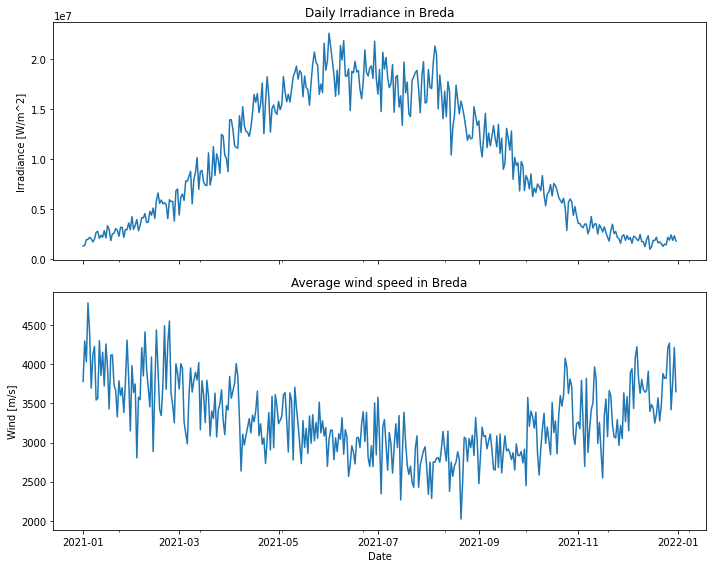

In [204]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
df.groupby('date')['Irradiance [W/m^2]'].sum().plot(ax=axs[0])
df.groupby('date')['Wind [m/s]'].mean().plot(ax=axs[1])
axs[0].set_ylabel('Irradiance [W/m^2]')
axs[0].set_xlabel('Date')
axs[0].set_title('Daily Irradiance in Breda')
axs[1].set_ylabel('Wind [m/s]')
axs[1].set_xlabel('Date')
axs[1].set_title('Average wind speed in Breda')
plt.tight_layout()

In [205]:
climate_df = df.copy()  # save a copy of the dataframe

## 2. Clean electricity consumption Data for non residential buildings

In [206]:
def reset_date_index(df, date):
    """ Reset the index of the dataframe to a date.
    :arg df: dataframe
    :arg date: date
    :return: dataframe
    """
    df = df.reset_index()
    df['index'] = df['index'].astype(str)
    df['index'] = df['index'].apply(lambda x: str(date) + ' ' + x)
    df['index'] = pd.to_datetime(df['index'])
    df.set_index('index', drop=True, inplace=True)
    return df

Following are the details of anonymous data.
1. Office 1
    * Area: 9375 m2
    * location: Handelsweg, NL
2. Office 2
    * Area: 8808 m2
    * location: Eindhoven, Limburglaan, NL
3. Office 3
    * Area: 3500 m2
    * location: Maastricht Afrikalaan, NL
4. Office 4
    * Area: 13500 m2
    * location: Heerlen, NL
5. School
    * Area: 27000 m2
    * location: Heerhugowaard, NL

In [207]:
#read data
df = pd.read_csv('raw/DataExport095911.csv', delimiter=';', decimal=',', parse_dates=['Tijdstip vanaf'])

In [208]:
# Convert to datetime
df['Tijdstip vanaf'] = pd.to_datetime(df['Tijdstip vanaf'], format='%Y-%m-%d %H:%M:%S')
df.rename(columns={'Tijdstip vanaf': 'Local'}, inplace=True)
df = df.set_index('Local')

In [209]:
# Extract dates in a column for easier handling
date = [datetime.datetime.strptime(str(index), '%Y-%m-%d %H:%M:%S').date() for index, row in df.iterrows()]
df['date'] = date

Check the completeness of the data

In [210]:
columns = df.columns.to_list()
columns = columns[0:-2]
index = df[df[columns].isna().any(axis=1)].index
print(index)

DatetimeIndex(['2021-03-28 01:45:00', '2021-03-28 02:00:00',
               '2021-03-28 02:15:00', '2021-03-28 02:30:00'],
              dtype='datetime64[ns]', name='Local', freq=None)


Above data points are missing from the same day. Therefore, electricity consumption data for 2021-01-28 is replaced with the electricity consumption data for 2021-01-21.

In [211]:
# Replace missing data with previous week's data
for i, row in df.loc[index, columns].iterrows():
    df.loc[i, :] = df.loc[i - datetime.timedelta(days=7), :]

In [212]:
# Perform completeness check again for four sites
index = df[df[columns].isna().any(axis=1)].index
print(index)

DatetimeIndex([], dtype='datetime64[ns]', name='Local', freq=None)


Now, managing the incomplete data for site 5 i.e. school.

In [213]:
columns = df.columns.to_list()[4]

In [214]:
for month in np.arange(1, 13):
    # Get all the values for the month
    df_m = pd.DataFrame(df[df[columns].index.month == month][columns])
    # Subset based on week day and weekend
    df_weekday = df_m[df_m.index.weekday.isin([1, 2, 3, 4, 5])]
    df_weekend = df_m[df_m.index.weekday.isin([6, 0])]
    # Calculate average weekday consumption
    avg_weekday = df_weekday.groupby(df_weekday.index.time).mean()
    # Calculate average weekend consumption
    avg_weekend = df_weekend.groupby(df_weekend.index.time).mean()
    # Create dataframe with average consumption for each hour
    avg_consumption = pd.DataFrame(columns=['weekday', 'weekend'])
    avg_consumption['weekday'] = avg_weekday
    avg_consumption['weekend'] = avg_weekend
    # Get dates of missing data in the weekend
    dates_missing_data = np.unique(df_m[df_m.isna()].index.date)
    # Replace missing data with average weekday/weekend consumption
    for date in dates_missing_data:
        filler_value = reset_date_index(avg_consumption, date)
        if int(date.weekday()) in [6, 0]:
            df_m.loc[str(date), columns] = filler_value['weekend']
        else:
            df_m.loc[str(date), columns] = filler_value['weekday']
    # Add the complete monthly data to the main dataframe
    df.loc[df[columns].index.month == month, columns] = df_m[columns]

Lastly, the school data has some faulty readings in form of outliers. Therefore, those faulty readings are replaced with the energy consumption of previous time step (i.e. 15 minutes ago).

In [215]:
for index, row in df.loc[df[columns] > 75, :].iterrows():
    df.loc[index, columns] = df.loc[index - datetime.timedelta(minutes=-15), columns]

In [216]:
# Perform completeness check again for all sites
df.isnull().sum()

Office 1    0
Office 2    0
Office 3    0
Office 4    0
School      0
date        0
dtype: int64

Hence, data is complete for all sites.

Text(0, 0.5, 'Consumption [kWh]')

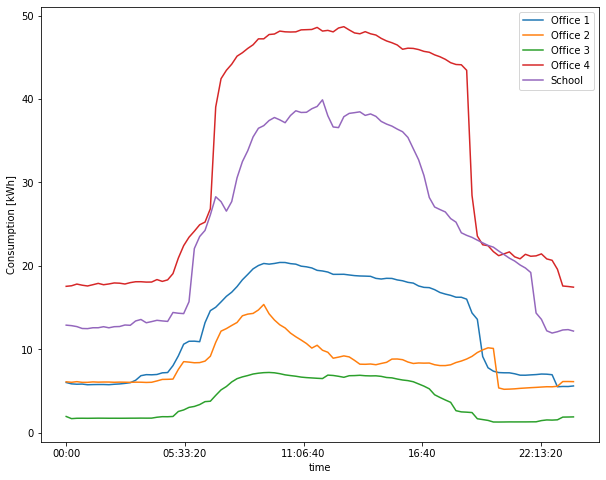

In [217]:
fig, ax = plt.subplots(figsize=(10, 8))
df.groupby(df.index.time).mean().plot(ax=ax, legend=True)
ax.set_ylabel('Consumption [kWh]')

In [218]:
df_non_commercial = df.copy()

## 3. Clean electricity consumption data for residential houses

In [219]:
# Read data
xls = pd.ExcelFile('raw/residential_electricity_consumption.xlsx')
hh1 = pd.read_excel(xls, 'DH28_e')
hh2 = pd.read_excel(xls, 'DH30_e')
hh3 = pd.read_excel(xls, 'DH32_e')

In [220]:
def extract_data(df):
    """Extract data by sensor name"""
    # Extract data for phase 1, phase 2 and phase 3
    sensor_name = ['Main connection - Phase1', 'Main connection - Phase2', 'Main connection - Phase3']
    df = df[df['Sensor_Name'].isin(sensor_name)]
    # Create a DateTime column
    df['DateTime'] = df['Date'] + ' ' + df['Time']
    return df

In [221]:
def get_data_by_sensor_name(df, sensor):
    # Extract data for sensor name
    df = df[df['Sensor_Name'] == sensor]
    # Rename the column with sensor name
    df.rename(columns={'Value [Wh]': sensor}, inplace=True)
    # Convert to kWh
    df[sensor] = df[sensor] / 1000
    # drop duplicate time stamps
    df.drop_duplicates(subset=['DateTime'], keep='first', inplace=True)
    return df

In [222]:
def calculate_total_consumption(df):
    # Extracting data ph phase 1, phase 2 and phase 3 for each house by sensor name
    p1 = get_data_by_sensor_name(df, 'Main connection - Phase1')
    p2 = get_data_by_sensor_name(df, 'Main connection - Phase2')
    p3 = get_data_by_sensor_name(df, 'Main connection - Phase3')
    # Create a dataframe with all three phases
    df = pd.merge(p1, p2[['DateTime', 'Main connection - Phase2']], on='DateTime', validate="one_to_one").merge(
        p3[['DateTime', 'Main connection - Phase3']], on='DateTime', validate="one_to_one")
    # Calculate total energy consumption
    df['consumption [kWh]'] = df['Main connection - Phase1'] + df['Main connection - Phase2'] + df[
        'Main connection - Phase3'] * 1.732
    # Smooth the data for hourly average consumption
    df['consumption [kWh]'] = df['consumption [kWh]'].rolling(window=4).mean()
    df = df[['DateTime', 'consumption [kWh]']].dropna().reset_index(drop=True)
    return df

In [223]:
# Extract data for phase 1, phase 2 and phase 3 for each house by sensor name
hh1 = extract_data(hh1)
hh2 = extract_data(hh2)
hh3 = extract_data(hh3)

In [224]:
# Calculate total energy consumption for each house
hh1 = calculate_total_consumption(hh1)
hh2 = calculate_total_consumption(hh2)
hh3 = calculate_total_consumption(hh3)

In [225]:
# Create a single dataframe with all three houses called 'hh
hh = pd.merge(hh1, hh2, on='DateTime', validate="one_to_one").merge(hh3, on='DateTime', validate="one_to_one")
hh.rename(columns={'consumption [kWh]': 'hh1_consumption [kWh]', 'consumption [kWh]_x': 'hh2_consumption [kWh]',
                   'consumption [kWh]_y': 'hh3_consumption [kWh]'}, inplace=True)
hh['DateTime'] = pd.to_datetime(hh['DateTime'])

In [226]:
# Create a new dataframe to find missing records
df_h = pd.DataFrame(columns=['DateTime'])
df_h['DateTime'] = pd.date_range(hh.DateTime.min(), hh.DateTime.max(), freq='15min')

In [227]:
# Merge to identify missing records
hh = pd.merge(df_h, hh, on='DateTime', how='left', indicator=True)
hh.set_index('DateTime', inplace=True)

In [228]:
# Count missing records
hh.isnull().sum()

hh2_consumption [kWh]    5030
hh3_consumption [kWh]    5030
hh1_consumption [kWh]    5030
_merge                      0
dtype: int64

In [229]:
# Fill missing records with average consumption (weekday or weekend) for each month
columns = ['hh1_consumption [kWh]', 'hh2_consumption [kWh]', 'hh3_consumption [kWh]']
for month in np.arange(1, 13):
    # Get all the values for the month
    df_m = pd.DataFrame(hh[hh[columns].index.month == month][columns])
    # Subset based on week day and weekend
    df_weekday = df_m[df_m.index.weekday.isin([1, 2, 3, 4, 5])]
    df_weekend = df_m[df_m.index.weekday.isin([6, 0])]
    # Calculate average weekday consumption
    avg_weekday = df_weekday.groupby(df_weekday.index.time).mean()
    # Calculate average weekend consumption
    avg_weekend = df_weekend.groupby(df_weekend.index.time).mean()
    # Get dates of missing data in the weekend
    dates_missing_data = np.unique(df_m[df_m.isna()].index.date)
    # Replace missing data with average weekday/weekend consumption
    for date in dates_missing_data:
        if int(date.weekday()) in [6, 0]:
            filler_value = reset_date_index(avg_weekend, date)
            df_m.loc[str(date), columns] = filler_value[columns]
        else:
            filler_value = reset_date_index(avg_weekday, date)
            df_m.loc[str(date), columns] = filler_value[columns]
    # Add the complete monthly data to the main dataframe
    hh.loc[hh[columns].index.month == month, columns] = df_m[columns]

In [230]:
# Extract the data for the year
hh = hh.loc['2020-01-01':'2020-12-31', columns]
hh.reset_index(inplace=True)
hh['DateTime'] = hh['DateTime'].astype('str')
hh = hh[~hh.DateTime.str.contains("2020-02-29")]
hh['DateTime'] = [item.replace('2020', '2021') for item in hh.DateTime]
hh['Local'] = pd.to_datetime(hh.DateTime, format='%Y-%m-%d %H:%M:%S')
hh.drop('DateTime', axis=1, inplace=True)

Text(0, 0.5, 'Consumption [kWh]')

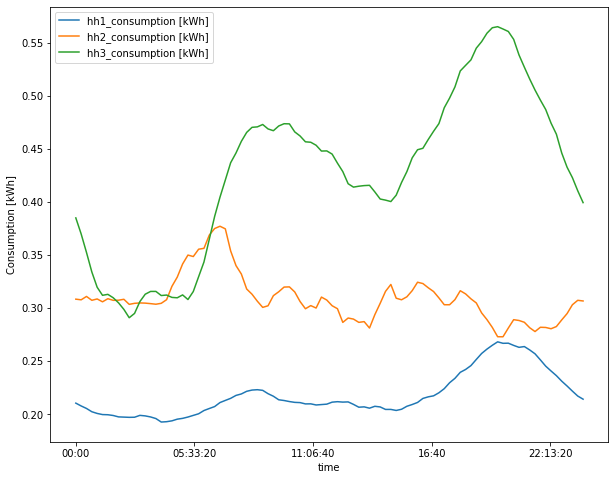

In [231]:
df = hh.copy()
df['Local'] = pd.to_datetime(df.Local)
df.set_index('Local', inplace=True)
fig, ax = plt.subplots(figsize=(10, 8))
df.groupby(df.index.time).mean().plot(ax=ax, legend=True)
ax.set_ylabel('Consumption [kWh]')

Above plot shows the hourly consumption of household 1, household 2 and household 3. It can be seen in that the consumption pattern as wells as the time of day is different for each house based on their load profile. These different load profiles will be used by the residential agents in the model.

## 4. Model EV charging data

The bus depot's EV charging is modeled using a linear model with the following parameters:
* Zero fast chargers of 45 kWh rating during daytime.
* 5 slow chargers of 6 kWh rating mostly during nighttime.
* Taking simultaneous charging of fast chargers and slow chargers also in to the account.

In [232]:
def get_fast_charger_demand(minimum_number_of_chargers=0, maximum_number_of_chargers=0):
    # Get the demand for the fast charger
    rating_fast_charger = 45
    number_of_chargers = round(np.random.uniform(minimum_number_of_chargers, maximum_number_of_chargers), 0)
    energy_consumption = number_of_chargers * rating_fast_charger
    return energy_consumption/100

In [233]:
def get_slow_charger_demand(lower_bound=2, upper_bound=10):
    # Get the demand for the slow charger
    rating_slow_charger = 6
    number_of_chargers = round(np.random.uniform(lower_bound, upper_bound), 0)
    energy_consumption = number_of_chargers * rating_slow_charger
    return energy_consumption/100

In [234]:
def get_ev_charging_demand():
    """Get the demand for the ev_charging"""
    date = '2021-01-01'
    timeseries = pd.date_range(start=date, periods=24, freq='60min')
    daytime = ['09:00:00', '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00', '15:00:00', '16:00:00',
               '17:00:00',
               '18:00:00']
    dict = {}
    dates = pd.date_range(start='2021-01-01', end='2021-12-31', freq='D')
    for date in dates.strftime('%Y-%m-%d'):
        for timestamp in timeseries.time:
            if str(timestamp) in daytime:
                lower_bound = 20
                upper_bound = 100
                dict[str(date + ' ' + str(timestamp))] = get_fast_charger_demand() + get_slow_charger_demand(
                    lower_bound, upper_bound)
            else:
                lower_bound = 40
                upper_bound = 100
                dict[str(date + ' ' + str(timestamp))] = get_slow_charger_demand(lower_bound, upper_bound)
    df = pd.DataFrame.from_dict(dict, orient='index', columns=['BusDepot [kWh]'])
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')
    df = df.resample('15min').mean().fillna(method='ffill')
    df = df.reset_index(inplace=False).rename(columns={'index': 'Local'}, inplace=False)
    return df

In [235]:
bus = get_ev_charging_demand()

## 5. Combine all the datasets

In [236]:
df = pd.merge(df_non_commercial, climate_df, left_index=True, right_index=True).merge(hh, on='Local')

In [237]:
df = pd.merge(df, bus, on='Local')

In [238]:
columns = ['Local', 'Office 1', 'Office 2', 'Office 3', 'Office 4', 'School', 'BusDepot [kWh]',
           'Irradiance [W/m^2]', 'T_ambient [Degrees Celsius]',
           'T_ground [Degrees Celsius]', 'Wind [m/s]', 'Cloud [okta]',
           'Pressure [Pa]', 'Rain [mm/hr]', 'Diffuse [W/m^2]', 'Direct [W/m^2]',
           'Elevation [Degrees]', 'Azimuth [Degrees]',
           'hh1_consumption [kWh]', 'hh2_consumption [kWh]',
           'hh3_consumption [kWh]']

In [239]:
df = df[columns]

In [240]:
# Checking data completeness
df.isnull().sum()

Local                          0
Office 1                       0
Office 2                       0
Office 3                       0
Office 4                       0
School                         0
BusDepot [kWh]                 0
Irradiance [W/m^2]             0
T_ambient [Degrees Celsius]    0
T_ground [Degrees Celsius]     0
Wind [m/s]                     0
Cloud [okta]                   0
Pressure [Pa]                  0
Rain [mm/hr]                   0
Diffuse [W/m^2]                0
Direct [W/m^2]                 0
Elevation [Degrees]            0
Azimuth [Degrees]              0
hh1_consumption [kWh]          0
hh2_consumption [kWh]          0
hh3_consumption [kWh]          0
dtype: int64

Store the data as a csv file

## 6. Save the data to a csv file

In [241]:
# Save the data to a csv file.
df.to_csv('processed/cleaned_data.csv', index=False)

## 7. Clean electricity pricing data

In [242]:
# Read the electricity pricing data

In [243]:
electricity_costs = pd.read_csv('raw/energy_costs_cbs.csv')

In [244]:
period = electricity_costs['Period'].str.split(' ', expand=True)
period.rename(columns={0: 'Year', 1: 'Month'}, inplace=True)

In [245]:
electricity_costs = electricity_costs.merge(period, left_index=True, right_index=True, how='inner')
electricity_costs.drop(columns=['Period'], inplace=True)

In [246]:
electricity_costs['Electricity Transport rate (Euro/day)'] = electricity_costs[
                                                                 'Electricity Transport rate (Euro/year)'] / 365
electricity_costs['Fixed delivery rate (Euro/day)'] = electricity_costs['Fixed delivery rate (Euro/year)'] / 365

In [247]:
electricity_costs.drop(columns=['Electricity Transport rate (Euro/year)', 'Fixed delivery rate (Euro/year)'],
                       inplace=True)

In [248]:
columns = ['Year', 'Month', 'Electricity Transport rate (Euro/day)', 'Fixed delivery rate (Euro/day)',
           'ODE tax (Environmental Taxes Act) (Euro/kWh)', 'Energy tax (Euro/kWh)', 'Variable delivery rate (Euro/kWh)']

In [249]:
electricity_costs = electricity_costs[columns]

In [250]:
electricity_costs.to_csv('processed/electricity_costs.csv', index=False)

____